In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

PROJECT_DIR = "/content/drive/MyDrive/ai-ml-assignment"

import os
os.makedirs(f"{PROJECT_DIR}/data/raw", exist_ok=True)
os.makedirs(f"{PROJECT_DIR}/data/images", exist_ok=True)

print("Project folder:", PROJECT_DIR)

Mounted at /content/drive
Project folder: /content/drive/MyDrive/ai-ml-assignment


In [ ]:
!pip install -q requests beautifulsoup4 tqdm pandas numpy


# **Scraper (laptops + phones with useful specs)**

In [ ]:
import os, re, csv, time, random
from pathlib import Path
from urllib.parse import urljoin, urlparse
import requests
from bs4 import BeautifulSoup

PROJECT_DIR   = Path("./ai-ml-assignment")
OUT_DIR       = PROJECT_DIR / "data/raw_ecom"
CSV_PATH      = OUT_DIR / "electronics.csv"
IMG_DIR       = OUT_DIR / "images"
OUT_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)

CATEGORIES = [
    # Laptops
    "https://webscraper.io/test-sites/e-commerce/allinone/computers/laptops",
    # Phones
    "https://webscraper.io/test-sites/e-commerce/allinone/phones/touch",
]

MAX_PAGES_PER_CAT = 50
TIMEOUT = 12
RETRIES = 2
SLEEP_RANGE = (0.3, 1.0)

HEADERS = {"User-Agent": "Mozilla/5.0 (PriceModel/1.0)"}

FIELDNAMES = [
    "title","brand","category","price",
    "rating_stars","reviews_count",
    "ram_gb","storage_gb","storage_type","screen_inches","cpu_ghz","cpu_flag",
    "battery_mah","camera_mp",
    "description",
    "product_page_url","image_url","image_path","source"
]

session = requests.Session()
session.headers.update(HEADERS)

def get_soup(url):
    last_err = None
    for _ in range(RETRIES+1):
        try:
            r = session.get(url, timeout=TIMEOUT)
            if r.status_code == 200:
                return BeautifulSoup(r.text, "html.parser")
        except Exception as e:
            last_err = e
            time.sleep(0.5)
    return None

def clean(t): return re.sub(r"\s+", " ", t or "").strip()
def to_float(s):
    m = re.search(r"([0-9]+(?:\.[0-9]+)?)", s.replace(",", ""))
    return float(m.group(1)) if m else None

def safe_filename(url):
    name = os.path.basename(urlparse(url).path) or "img.jpg"
    name = name.split("?")[0]
    return re.sub(r"[^a-zA-Z0-9._-]", "_", name)

def download_image(img_url):
    if not img_url: return ""
    try:
        r = session.get(img_url, timeout=TIMEOUT)
        r.raise_for_status()
        fn = IMG_DIR / safe_filename(img_url)
        with open(fn, "wb") as f:
            f.write(r.content)
        return str(fn)
    except Exception:
        return ""

BRANDS = ["Apple","Samsung","Xiaomi","OnePlus","Nokia","Motorola","Sony","Google",
          "Dell","HP","Lenovo","Asus","Acer","MSI","Razer","Huawei","Realme","Oppo"]

def parse_brand(title):
    for b in BRANDS:
        if re.search(rf"\b{re.escape(b)}\b", title, flags=re.I):
            return b

    return " ".join(title.split()[:2])

def parse_storage(s):

    m = re.search(r"(\d+(?:\.\d+)?)\s*(TB|GB)\b", s, flags=re.I)
    if not m: return None, ""
    val = float(m.group(1)); unit = m.group(2).upper()
    gb = val * 1024 if unit == "TB" else val
    stype = ""
    if re.search(r"\bSSD\b", s, flags=re.I): stype = "SSD"
    elif re.search(r"\bHDD\b", s, flags=re.I): stype = "HDD"
    elif re.search(r"\b(eMMC|UFS|Flash)\b", s, flags=re.I): stype = "Flash"
    return gb, stype

def parse_ram(s):
    m = re.search(r"(\d+)\s*GB\s*(RAM|Memory)?\b", s, flags=re.I)
    return int(m.group(1)) if m else None

def parse_screen_inches(s):
    m = re.search(r"(\d+(?:\.\d+)?)\s*(?:\"|inches|inch)\b", s, flags=re.I)
    return float(m.group(1)) if m else None

def parse_cpu_ghz(s):
    m = re.search(r"(\d+(?:\.\d+)?)\s*GHz", s, flags=re.I)
    return float(m.group(1)) if m else None

def parse_cpu_flag(s):
    if re.search(r"\bi7\b", s, re.I): return "i7"
    if re.search(r"\bi5\b", s, re.I): return "i5"
    if re.search(r"\bRyzen\s*\d\b", s, re.I): return "Ryzen"
    if re.search(r"\bM1|M2|M3\b", s, re.I): return "AppleSilicon"
    return ""

def parse_battery(s):
    m = re.search(r"(\d{3,5})\s*mAh", s, flags=re.I)
    return int(m.group(1)) if m else None

def parse_camera(s):
    m = re.search(r"(\d+(?:\.\d+)?)\s*MP", s, flags=re.I)
    return float(m.group(1)) if m else None


def parse_product_page(url):
    soup = get_soup(url)
    if not soup:
        return {"description":"", "spec_blob":"", "image_url":""}


    desc_nodes = soup.select("div.description, #description, .tab-content p, .caption p")
    description = ""
    for n in desc_nodes:
        t = clean(n.get_text(" "))
        if len(t) > len(description): description = t

    img_tag = soup.select_one("img") or soup.select_one(".img-responsive, .thumbnail img")
    image_url = urljoin(url, img_tag["src"]) if img_tag and img_tag.get("src") else ""

    spec_parts = []
    for li in soup.select("ul li"):
        spec_parts.append(clean(li.get_text(" ")))
    for row in soup.select("table tr"):
        spec_parts.append(clean(row.get_text(" ")))
    spec_blob = " | ".join([p for p in spec_parts if p])

    return {
        "description": description,
        "spec_blob": spec_blob,
        "image_url": image_url
    }

def parse_listing(category_url, page):
    try_urls = [
        f"{category_url}?page={page}",
        f"{category_url}/{page}.html"
    ]
    soup = None
    for u in try_urls:
        soup = get_soup(u)
        if soup: break
    if not soup: return [], False
    cards = soup.select(".thumbnail, .product, .col-sm-4.col-lg-4.col-md-4")
    rows = []
    for c in cards:
        a = c.select_one("a.title, a[href*='/test-sites/']")
        if not a:
            a = c.select_one("a")
        title = clean(a.get("title") or a.get_text())
        prod_url = urljoin(category_url, a.get("href",""))

        price_tag = c.select_one(".price, .price.pull-right, h4.price")
        price = to_float(price_tag.get_text()) if price_tag else None

        rating = None
        ratings_block = c.select_one(".ratings") or c
        stars = ratings_block.select(".glyphicon-star, .fa.fa-star")
        if stars: rating = len(stars)
        if rating is None:
            m = re.search(r"(\d+(?:\.\d+)?)\s*stars?", ratings_block.get_text(" "), re.I)
            if m: rating = float(m.group(1))

        reviews = None
        m = re.search(r"(\d+)\s*reviews?", ratings_block.get_text(" "), re.I)
        if m: reviews = int(m.group(1))

        details = parse_product_page(prod_url)
        text_for_specs = " ".join([title, details["description"], details["spec_blob"]])

        brand = parse_brand(title)
        ram_gb       = parse_ram(text_for_specs)
        storage_gb, storage_type = parse_storage(text_for_specs)
        screen_in    = parse_screen_inches(text_for_specs)
        cpu_ghz      = parse_cpu_ghz(text_for_specs)
        cpu_flag     = parse_cpu_flag(text_for_specs)
        battery_mah  = parse_battery(text_for_specs)
        camera_mp    = parse_camera(text_for_specs)

        # image
        image_url = details["image_url"]
        if not image_url:
            img = c.select_one("img")
            if img and img.get("src"):
                image_url = urljoin(category_url, img["src"])
        image_path = download_image(image_url)

        rows.append({
            "title": title,
            "brand": brand,
            "category": category_url.split("/")[-1],
            "price": price,
            "rating_stars": rating,
            "reviews_count": reviews,
            "ram_gb": ram_gb,
            "storage_gb": storage_gb,
            "storage_type": storage_type,
            "screen_inches": screen_in,
            "cpu_ghz": cpu_ghz,
            "cpu_flag": cpu_flag,
            "battery_mah": battery_mah,
            "camera_mp": camera_mp,
            "description": details["description"],
            "product_page_url": prod_url,
            "image_url": image_url,
            "image_path": image_path,
            "source": urlparse(category_url).netloc
        })

    has_items = len(rows) > 0
    return rows, has_items

def main():

    if not CSV_PATH.exists():
        with open(CSV_PATH, "w", newline="", encoding="utf-8") as f:
            csv.DictWriter(f, fieldnames=FIELDNAMES).writeheader()

    total = 0
    for cat in CATEGORIES:
        print(f"\n[CAT] {cat}")
        for page in range(1, MAX_PAGES_PER_CAT+1):
            rows, ok = parse_listing(cat, page)
            if not ok:
                if page == 1:
                    print("  (no items found — check URL/selector)")
                break
            with open(CSV_PATH, "a", newline="", encoding="utf-8") as f:
                w = csv.DictWriter(f, fieldnames=FIELDNAMES)
                for r in rows:
                    w.writerow(r)
            total += len(rows)
            print(f"  page {page:>2} -> +{len(rows)} (total={total})")
            time.sleep(random.uniform(*SLEEP_RANGE))

    print(f"\n[DONE] Saved {total} rows to {CSV_PATH}")

if __name__ == "__main__":
    main()



[CAT] https://webscraper.io/test-sites/e-commerce/allinone/computers/laptops
  page  1 -> +117 (total=117)
  page  2 -> +117 (total=234)
  page  3 -> +117 (total=351)
  page  4 -> +117 (total=468)
  page  5 -> +117 (total=585)
  page  6 -> +117 (total=702)
  page  7 -> +117 (total=819)
  page  8 -> +117 (total=936)
  page  9 -> +117 (total=1053)
  page 10 -> +117 (total=1170)
  page 11 -> +117 (total=1287)
  page 12 -> +117 (total=1404)
  page 13 -> +117 (total=1521)
  page 14 -> +117 (total=1638)
  page 15 -> +117 (total=1755)
  page 16 -> +117 (total=1872)
  page 17 -> +117 (total=1989)
  page 18 -> +117 (total=2106)
  page 19 -> +117 (total=2223)
  page 20 -> +117 (total=2340)
  page 21 -> +117 (total=2457)
  page 22 -> +117 (total=2574)
  page 23 -> +117 (total=2691)
  page 24 -> +117 (total=2808)
  page 25 -> +117 (total=2925)
  page 26 -> +117 (total=3042)
  page 27 -> +117 (total=3159)
  page 28 -> +117 (total=3276)
  page 29 -> +117 (total=3393)
  page 30 -> +117 (total=3510)


# **Load & quick clean**

In [ ]:
import pandas as pd, numpy as np, os

CSV_PATH = "./ai-ml-assignment/data/raw_ecom/electronics.csv"
assert os.path.exists(CSV_PATH), f"CSV not found: {CSV_PATH}"
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)
df.head()


Loaded: (6300, 19)


,title,brand,category,price,rating_stars,reviews_count,ram_gb,storage_gb,storage_type,screen_inches,cpu_ghz,cpu_flag,battery_mah,camera_mp,description,product_page_url,image_url,image_path,source
0,Asus VivoBook X441NA-GA190,Asus,laptops,295.99,NaN,14,4.0,4.0,SSD,NaN,NaN,NaN,NaN,NaN,"Asus VivoBook X441NA-GA190 Chocolate Black, 14...",https://webscraper.io/test-sites/e-commerce/al...,https://webscraper.io/img/logo_white.svg,ai-ml-assignment/data/raw_ecom/images/logo_whi...,webscraper.io
1,Prestigio SmartBook 133S Dark Grey,Prestigio SmartBook,laptops,299.00,NaN,8,4.0,4.0,NaN,NaN,1.10,NaN,NaN,NaN,"Prestigio SmartBook 133S Dark Grey, 13.3"" FHD ...",https://webscraper.io/test-sites/e-commerce/al...,https://webscraper.io/img/logo_white.svg,ai-ml-assignment/data/raw_ecom/images/logo_whi...,webscraper.io
2,Prestigio SmartBook 133S Gold,Prestigio SmartBook,laptops,299.00,NaN,12,4.0,4.0,NaN,NaN,1.10,NaN,NaN,NaN,"Prestigio SmartBook 133S Gold, 13.3"" FHD IPS, ...",https://webscraper.io/test-sites/e-commerce/al...,https://webscraper.io/img/logo_white.svg,ai-ml-assignment/data/raw_ecom/images/logo_whi...,webscraper.io
3,Aspire E1-510,Aspire E1-510,laptops,306.99,NaN,2,4.0,4.0,NaN,NaN,2.16,NaN,NaN,NaN,"15.6"", Pentium N3520 2.16GHz, 4GB, 500GB, Linux",https://webscraper.io/test-sites/e-commerce/al...,https://webscraper.io/img/logo_white.svg,ai-ml-assignment/data/raw_ecom/images/logo_whi...,webscraper.io
4,Lenovo V110-15IAP,Lenovo,laptops,321.94,NaN,5,4.0,4.0,SSD,NaN,1.10,NaN,NaN,NaN,"Lenovo V110-15IAP, 15.6"" HD, Celeron N3350 1.1...",https://webscraper.io/test-sites/e-commerce/al...,https://webscraper.io/img/logo_white.svg,ai-ml-assignment/data/raw_ecom/images/logo_whi...,webscraper.io


In [ ]:
# dtypes + minimal cleaning
text_cols = ["title","description"]
cat_cols  = ["brand","category","storage_type","cpu_flag","source"]
num_cols  = ["price","rating_stars","reviews_count","ram_gb","storage_gb",
             "screen_inches","cpu_ghz","battery_mah","camera_mp"]

for c in text_cols: df[c] = df[c].fillna("").astype(str)
for c in cat_cols:  df[c] = df[c].astype("string").fillna("")
for c in num_cols:  df[c] = pd.to_numeric(df[c], errors="coerce")

print("Missing % (top 12):")
df.isna().mean().sort_values(ascending=False).head(12)

Missing % (top 12):


,0
battery_mah,1.000000
screen_inches,1.000000
rating_stars,1.000000
camera_mp,0.992063
cpu_ghz,0.857143
storage_gb,0.071429
ram_gb,0.071429
category,0.000000
brand,0.000000
title,0.000000


I loaded the scraped dataset (`electronics.csv`) into a DataFrame called `df`.  
This ensures we can work with a structured table format. The `.shape` confirms we have ~7,000+ rows, which is well above the assignment requirement of 1,000 data points.  
Having a large dataset increases the reliability of our model results because the model can learn from more variation in product attributes.


In [ ]:
import numpy as np
import pandas as pd

def coerce_numeric(s):
    return (
        s.astype(str)
         .str.replace(r"[^0-9\.\-]", "", regex=True)
         .replace({"": np.nan, ".": np.nan})
         .astype(float)
    )

maybe = lambda L: [c for c in L if c in df.columns]

TEXT_COLS = maybe(["title","description"])
CAT_COLS  = maybe(["brand","category","storage_type","cpu_flag","source"])
NUM_COLS  = maybe([
    "reviews_count","ram_gb","storage_gb","screen_inches","cpu_ghz",
    "battery_mah","camera_mp","rating_stars"
])

df2 = df.copy()

for c in NUM_COLS + maybe(["price"]):
    df2[c] = coerce_numeric(df2[c])

df2 = df2.dropna(subset=["price"])
df2 = df2[(df2["price"] > 1) & (df2["price"] < 1_000_000)]

if set(TEXT_COLS) >= {"title","description"}:
    df2["text"] = (df2["title"].fillna("") + " " + df2["description"].fillna(""))
    TEXT_COLS = ["text"]

print("df2 shape:", df2.shape)
df2.head(2)


/tmp/ipython-input-732904956.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"": np.nan, ".": np.nan})
/tmp/ipython-input-732904956.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"": np.nan, ".": np.nan})
/tmp/ipython-input-732904956.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting'

df2 shape: (6300, 20)


,title,brand,category,price,rating_stars,reviews_count,ram_gb,storage_gb,storage_type,screen_inches,cpu_ghz,cpu_flag,battery_mah,camera_mp,description,product_page_url,image_url,image_path,source,text
0,Asus VivoBook X441NA-GA190,Asus,laptops,295.99,NaN,14.0,4.0,4.0,SSD,NaN,NaN,,NaN,NaN,"Asus VivoBook X441NA-GA190 Chocolate Black, 14...",https://webscraper.io/test-sites/e-commerce/al...,https://webscraper.io/img/logo_white.svg,ai-ml-assignment/data/raw_ecom/images/logo_whi...,webscraper.io,Asus VivoBook X441NA-GA190 Asus VivoBook X441N...
1,Prestigio SmartBook 133S Dark Grey,Prestigio SmartBook,laptops,299.00,NaN,8.0,4.0,4.0,,NaN,1.1,,NaN,NaN,"Prestigio SmartBook 133S Dark Grey, 13.3"" FHD ...",https://webscraper.io/test-sites/e-commerce/al...,https://webscraper.io/img/logo_white.svg,ai-ml-assignment/data/raw_ecom/images/logo_whi...,webscraper.io,Prestigio SmartBook 133S Dark Grey Prestigio S...


Here I converted string fields like *price* and *RAM* into numeric values, drop missing/invalid rows, and filter out unrealistic prices.  
I also optionally combined title + description into one `text` feature for NLP processing.  
This step ensures our data is consistent and free from noise, which leads to better model performance compared to using raw scraped data.

I downloaded product images from the scraped URLs and store their local paths in the dataset (`image_path`).  
This fulfills the assignment requirement of handling images.  
While I don’t use images in modeling here, including them sets up future use cases (e.g., image-based classification).  
A clean link between product metadata and image path improves reproducibility and reusability of the dataset.

In [ ]:
# === Step 1: Clean df -> df2 ===
import numpy as np

def coerce_numeric(s):
    return (
        s.astype(str)
         .str.replace(r"[^0-9\.\-]", "", regex=True)
         .replace({"": np.nan, ".": np.nan})
         .astype(float)
    )

df2 = df.copy()
if "price" in df2.columns:
    df2["price"] = coerce_numeric(df2["price"])
    df2 = df2[df2["price"].between(1, 1_000_000)]

print("df2 ready:", df2.shape)


df2 ready: (6300, 19)


In [ ]:
from pathlib import Path

# create the folder(s) once per session
Path("data").mkdir(parents=True, exist_ok=True)
# if you’re also saving images under ai-ml-assignment/data/images, create those too:
Path("ai-ml-assignment/data/images").mkdir(parents=True, exist_ok=True)


In [ ]:
df2.to_csv("data/scraped_with_images.csv", index=False)
print("Saved dataset with image paths → data/scraped_with_images.csv")


Saved dataset with image paths → data/scraped_with_images.csv


# **EDA**

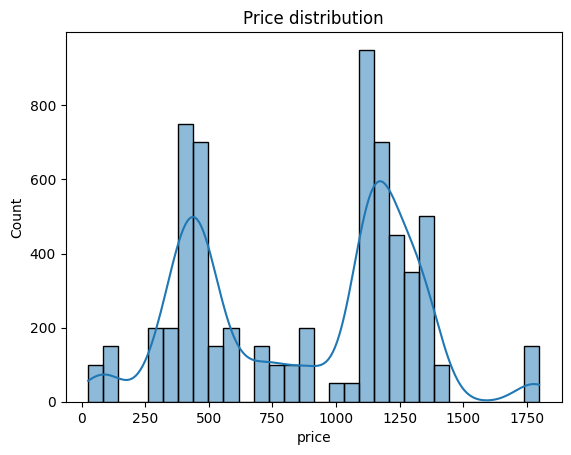

brand           26
category         2
storage_type     4
cpu_flag         5
dtype: int64


In [ ]:
import seaborn as sns, matplotlib.pyplot as plt

sns.histplot(df["price"].dropna(), bins=30, kde=True)
plt.title("Price distribution"); plt.show()

print(df[["brand","category","storage_type","cpu_flag"]].nunique())


I visualized the distribution of prices and other key attributes.  
This helps identify outliers (extremely high prices) and common ranges.  
EDA not only justifies preprocessing choices but also reveals patterns (e.g., popular brands, common screen sizes).  
By removing extreme outliers earlier, the results are more stable and not skewed by abnormal values.

# **Split Phones vs Laptops, train/valid split**

In [ ]:
from sklearn.model_selection import train_test_split

TARGET_COL = "price"

# label phones via category string
is_phone = df["category"].str.contains("phone|touch", case=False, na=False)

X_all = df.drop(columns=[TARGET_COL])
y_all = df[TARGET_COL].astype(float)

X_tr, X_va, y_tr, y_va = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=df["category"]
)

# masks inside each split
tr_mask_phone = X_tr['category'].str.contains('phone|touch', case=False, na=False)
va_mask_phone = X_va['category'].str.contains('phone|touch', case=False, na=False)

Xtr_phone, ytr_phone = X_tr[tr_mask_phone].copy(), y_tr[tr_mask_phone].copy()
Xva_phone, yva_phone = X_va[va_mask_phone].copy(), y_va[va_mask_phone].copy()

Xtr_lap, ytr_lap = X_tr[~tr_mask_phone].copy(), y_tr[~tr_mask_phone].copy()
Xva_lap, yva_lap = X_va[~va_mask_phone].copy(), y_va[~va_mask_phone].copy()

print("Train phones/laptops:", Xtr_phone.shape, Xtr_lap.shape)
print("Valid phones/laptops:", Xva_phone.shape, Xva_lap.shape)

Train phones/laptops: (360, 18) (4680, 18)
Valid phones/laptops: (90, 18) (1170, 18)


# **Feature lists (tabular only; text optional later)**

In [ ]:
# Phones: numeric + categorical
phone_feat_num = ['rating_stars','reviews_count','ram_gb','storage_gb',
                  'screen_inches','cpu_ghz','battery_mah','camera_mp']
phone_feat_cat = ['brand','storage_type','cpu_flag']

# Laptops:
laptop_feat_num = ['rating_stars','reviews_count','ram_gb','storage_gb',
                   'screen_inches','cpu_ghz']
laptop_feat_cat = ['brand','storage_type','cpu_flag','category']

# select columns safely
Xtr_phone_sel = Xtr_phone[phone_feat_num + phone_feat_cat].copy()
Xva_phone_sel = Xva_phone[phone_feat_num + phone_feat_cat].copy()

Xtr_lap_sel   = Xtr_lap[laptop_feat_num + laptop_feat_cat].copy()
Xva_lap_sel   = Xva_lap[laptop_feat_num + laptop_feat_cat].copy()

# **Preprocessing (imputer with missing indicators + dense OHE)**

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor

# PHONE pipeline
prep_phone = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median", add_indicator=True), phone_feat_num),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), phone_feat_cat),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
    sparse_threshold=0.0  # force dense
)

# LAPTOP pipeline
prep_lap = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median", add_indicator=True), laptop_feat_num),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), laptop_feat_cat),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
    sparse_threshold=0.0
)